# Training TransformerAE

This notebook shows how to train the anomaly detection model.

In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import optuna

from models import RelationalSTAE, TransformerAutoencoder
from parameters import TransformerAEParameters, TrainingParameters
from datautils import get_temporal_sequence
from training import save_model, load_model, train_transformerae, compute_anomaly_threshold_transformerae, test_transformerae, threshold_anomalies, fill_result_df
import torch.nn as nn
from tqdm import tqdm

import random
import os

In [64]:
mse_weights = [1,1,1] # weights for loss function (occupancy, speed, volume)

In [65]:
training_params = TrainingParameters(
    learning_rate=1e-4,
    batch_size=1,
    timesteps=10,
    n_epochs=3
)

In [66]:
training_data = get_temporal_sequence(1, timesteps=training_params.timesteps) # train on day 1, free of crashes

In [67]:
hyperparams = TransformerAEParameters(
    num_features=3,
    latent_dim=2,
    hidden_dim=64,
    num_heads=1,
    num_layers=2,
    sequence_length=training_params.timesteps
)

In [68]:
ae = TransformerAutoencoder(hyperparams)

In [69]:
ae(training_data[0][0]).shape

torch.Size([196, 3])

In [70]:
ae, losses = train_transformerae(params=hyperparams, trainingparams=training_params, training_data=training_data, mse_weights=mse_weights, verbose=True)

 33%|███▎      | 1/3 [00:23<00:47, 23.70s/it]

Epoch number 0 last 100 loss 0.5715322145819663


 67%|██████▋   | 2/3 [00:46<00:23, 23.32s/it]

Epoch number 1 last 100 loss 0.27475499987602237


100%|██████████| 3/3 [01:11<00:00, 23.99s/it]

Epoch number 2 last 100 loss 0.15230787351727484


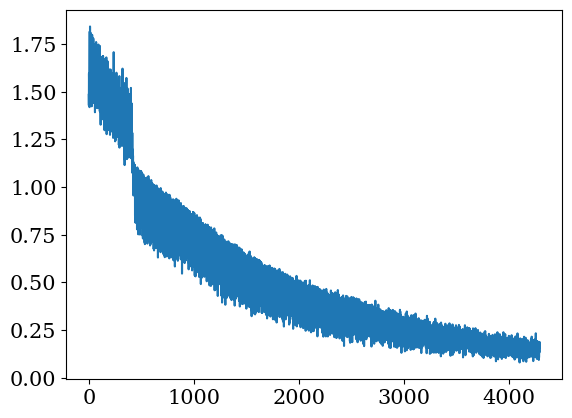

In [71]:
plt.plot(losses)

In [72]:
thresh = compute_anomaly_threshold_transformerae(training_data, ae, mse_weights, 'max')

100%|██████████| 1430/1430 [00:06<00:00, 210.45it/s]


In [73]:
use_pretrained = False
if not use_pretrained:
    test_data = get_temporal_sequence(4, timesteps=training_params.timesteps)

In [74]:
test_errors, test_recons_speeds, test_true_speeds = test_transformerae(test_data, mse_weights, ae)

In [75]:
np.mean(test_errors)

0.07578258

In [76]:
np.max(test_errors)*80

38.759963512420654

In [77]:
anomalies = threshold_anomalies(thresh/2, test_errors)

In [78]:
df = fill_result_df(anomalies, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [79]:
df.to_csv('./saved_results/day4_results_test_transformerae.csv')

51.328907199999996 51.3295176


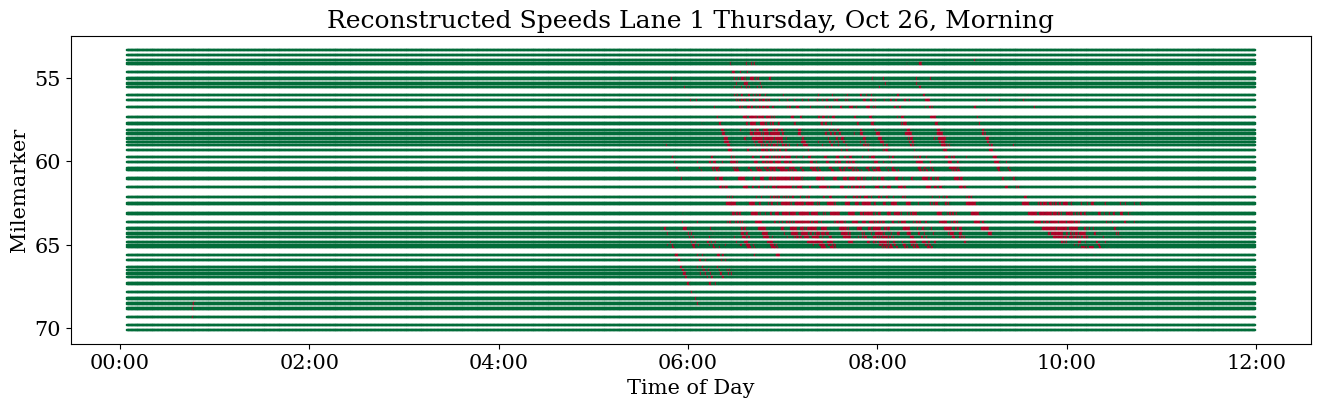

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv('./saved_results/day4_results_test_transformerae.csv', index_col=0)
data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
print(min(lane['Reconstructed Speed'].values*80), max(lane['Reconstructed Speed'].values*80))
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed']),marker='s',s=1, cmap='viridis')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

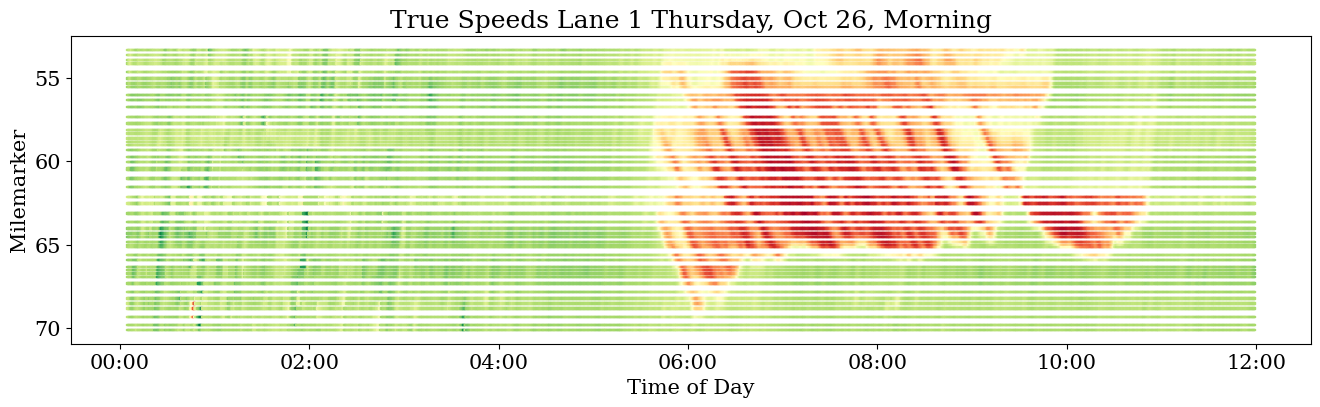

In [81]:
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 09:30:00')
end_time = pd.to_datetime('1970-01-01 09:50:00')
# plt.xlim(start_time, end_time)
# plt.ylim()

plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

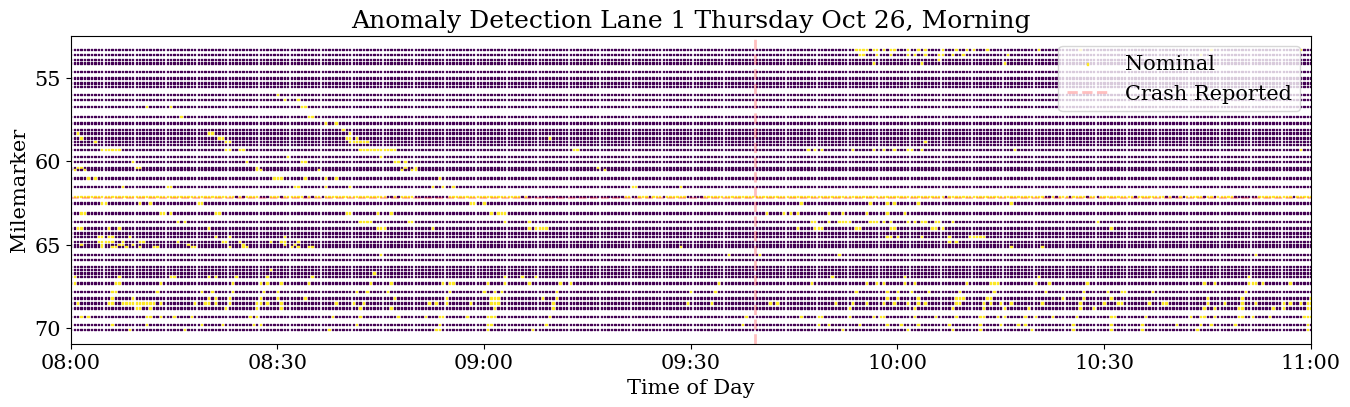

In [82]:
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 08:00:00')
end_time = pd.to_datetime('1970-01-01 11:00:00')
plt.xlim(start_time, end_time)

# Add vertical line at '1970-01-01 09:39:22'
vline_time = pd.to_datetime('1970-01-01 09:39:22')
plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# plt.ylim(60,65)
plt.legend(loc='upper right')
plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()